## Visualize Training History

In [1]:
# Load libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create training and test sets
features, target = make_classification(n_classes=2, n_features=10,
n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.1, random_state=1)

In [3]:
# Set random seed
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

In [5]:
# Define a neural network using `Sequential`
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
        torch.nn.Linear(10, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16,16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 1),
        torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = self.sequential(x)
        return x

In [6]:
# Initialize neural network
network = SimpleNeuralNet()
# Define loss function, optimizer
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())
# Define data loader
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
# Compile the model using torch 2.0's optimizer
network = torch.compile(network)

In [7]:
# Train neural network
epochs = 8
train_losses = []
test_losses = []
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_output = network(x_train)
        train_loss = criterion(output, target)
        train_losses.append(train_loss.item())
        test_output = network(x_test)
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())

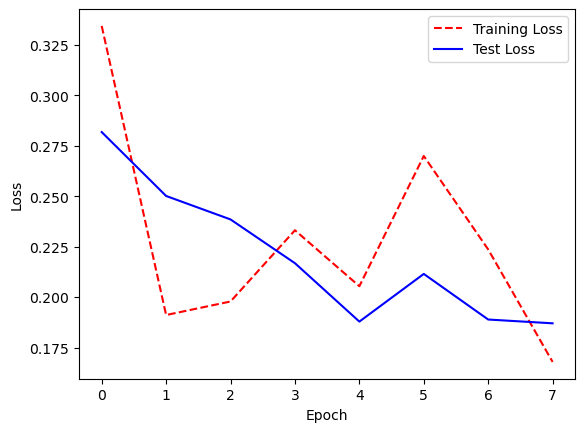

In [8]:
# Visualize loss history
epochs = range(0, epochs)
plt.plot(epochs, train_losses, "r--")
plt.plot(epochs, test_losses, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

## Saving Model Training Progress

We can use torch.save to alleviate this problem by saving the model after every
epoch. Specifically, after every epoch, we save a model to the location model.pt , the
second argument to the torch.save function. If we include only a filename (e.g.,
model.pt) that file will be overridden with the latest model every epoch.
As you can imagine, we can introduce additional logic to save the model every few
epochs, only save a model if the loss goes down, etc. We could even combine this
approach with the early stopping approach in PyTorch Lightning to ensure we save a
model no matter at what epoch the training ends

In [9]:
# Load libraries
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [10]:
# Create training and test sets
features, target = make_classification(n_classes=2, n_features=10,
n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.1, random_state=1)
# Set random seed
torch.manual_seed(0)
np.random.seed(0)
# Convert data to PyTorch tensors
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

In [11]:
# Define a neural network using `Sequential`
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
        torch.nn.Linear(10, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16,16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 1),
        torch.nn.Dropout(0.1), # Drop 10% of neurons
        torch.nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.sequential(x)
        return x

In [12]:
# Initialize neural network
network = SimpleNeuralNet()
# Define loss function, optimizer
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())
# Define data loader
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
# Compile the model using torch 2.0
network = torch.compile(network)
epochs = 5

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # Save the model at the end of every epoch
        torch.save(
        {
        'epoch': epoch,
        'model_state_dict': network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        },
        "model.pt"
        )
    print("Epoch:", epoch+1, "\tLoss:", loss.item())


Epoch: 1 	Loss: 0.20735645294189453
Epoch: 2 	Loss: 0.20834866166114807
Epoch: 3 	Loss: 0.25975286960601807
Epoch: 4 	Loss: 0.1492830067873001
Epoch: 5 	Loss: 0.20664513111114502
